## Use multiple Scopus Author IDs to retrieve lists of articles by author

In [54]:
# Dependencies
import requests
import json
import pandas as pd
import numpy as np
from config import api_key
from pandas.io.json import json_normalize  
import nltk
import re
import io
from nltk.corpus import stopwords, reuters
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import panel as pn
import panel.widgets 
from pathlib import Path
from panel.interact import interact
import hvplot.pandas
import param
from IPython.display import Image
from IPython.core.display import HTML
import time
import datetime as dt
lemmatizer = WordNetLemmatizer()
pn.extension()

In [2]:
# Declare necessary parameters for Scopus request API search tool
url = "http://api.elsevier.com/content/search/scopus?" + "cursor=*"
headers = {"X-ELS-APIKey": api_key, 'Accept':'application/json'}
view = "Complete"

In [3]:
# Declare the timeframe to search by start and end years
# Year is the lowest granularity for this search function
start_year = 2008
end_year = 2009
if start_year == end_year:
    date = str(start_year)
else: 
    date = str(start_year) + "-" + str(end_year)

# Generate a lists of dates for the requested timeframe
date_list = []
for date in range(start_year, end_year + 1):
    date_list.append(int(date))
    
#date_list

In [4]:
# Input the query search term
query = "Nanosafety"

In [5]:
# Test search function to determine the total results from the Get Request for the Specified Date Range
total_results = []
date_list = []
for date in range(start_year, end_year + 1):
    date_list.append(int(date))
    
def total_results_funt(start_year, end_year):
    parameters = {"query": query, "view": view, "date": str(start_year) + "-" + str(end_year), }
    article_response = requests.get(url, headers=headers, params=parameters)
    article_response_json = article_response.json()
    total_results.append(int(article_response_json['search-results']['opensearch:totalResults']))
    return total_results

total_results = total_results_funt(start_year, end_year)
total_results

[88]

Tabs
    [0] Column(background='#f0f0f0')
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Row
            [0] Column
                [0] Param(search_scopus_dash, name='Query Search R..., widgets={'Query': <class 'panel.wi...})
                [1] FileDownload(callback=<bound method search_scopu..., filename='Scopus Search E..., label='Download Scopus S...)
            [1] ParamMethod(method)
    [1] Column(background='#f0f0f0')
        [0] Markdown(str)
        [1] Row
            [0] ParamMethod(method)
    [2] Column(background='#f0f0f0')
        [0] Markdown(str)
        [1] Row
            [0] Column(margin=5, name='Query Search R..., width=300)
                [0] StaticText(value='<b>Query Search R...)
                [1] TextInput(name='Query', value='Nanosafety')
                [2] RangeSlider(end=2021, name='Year Range', start=1970, step=1, value=(2005, 2010))
                [3] Select(name='Column Selector', options=OrderedDict([('Title', ...]), value='Title')
                [4] IntSlider(end=50, name='Word Slider', start=5, value=15)
                [5] TextInput(name='Text Input')
            [1] Column
                [0] ParamMethod(method)
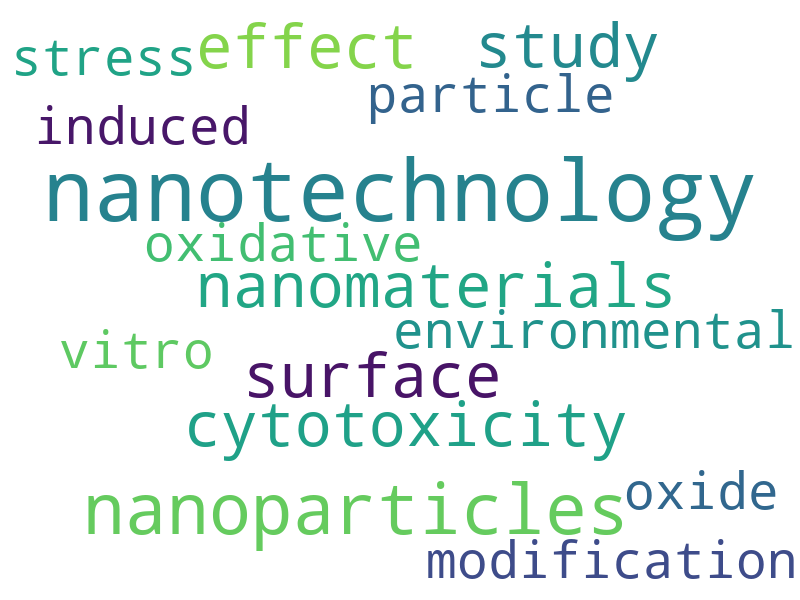

In [101]:
# Search request function 
class search_scopus_dash(param.Parameterized):

    Query  = param.String(default="Nanosafety", doc="Insert query term(s)")
    
    Year_Range = param.Range((2005, 2010), bounds=(1970, 2021))
    
    # Y value multiselectors
    Column_Selector = param.ObjectSelector(default = 'Title', objects=['Title', 'Content'])

    # Word Count Slider
    Word_Slider = param.Integer(15, bounds=(5,50))

    # Stop word addition
    Text_Input = param.String(default='', doc= 'Type Words Here, Seperated by a Space')

    @param.depends('Query', 'Year_Range', 'Column_Selector', 'Word_Slider', 'Text_Input')
    def search_request_funt(self):
    
        scopus_search_appended_df = pd.DataFrame()
    
        if self.Year_Range[0] == self.Year_Range[1]:
            date = str(self.Year_Range[0])
        else: 
            date = str(self.Year_Range[0]) + "-" + str(self.Year_Range[1])
        cursor = "*"
        field = "prism:coverDate,dc:title,dc:description"
        url = "http://api.elsevier.com/content/search/scopus?"
    
        parameters = {"query": self.Query, "view": "Complete", "date": date, "field": field, "cursor": cursor}
        article_response = requests.get(url, headers=headers, params=parameters)
        article_response_json = article_response.json()
        total_results = int(article_response_json['search-results']['opensearch:totalResults'])
        while article_response_json['search-results'].get('entry') is not None:
            url = "http://api.elsevier.com/content/search/scopus?"
            parameters = {"query": self.Query, "view": "Complete", "date": date, "field": field, "cursor": cursor}
            article_response = requests.get(url, headers=headers, params= parameters)
            article_response_json = article_response.json()
            if article_response_json['search-results'].get('entry') is not None:
                scopus_articles_df = pd.DataFrame.from_dict(json_normalize(article_response_json, meta=["search-results"], record_path=["search-results", "entry"]), orient="columns")
                date_title_description_df = scopus_articles_df[["prism:coverDate", "dc:title", "dc:description"]]
                date_title_description_df.columns = ['Date','Title','Content']
                pd.to_datetime(date_title_description_df['Date'], format = "%Y-%m-%d")
                date_title_description_df.sort_values(by='Date')
                date_title_description_df = date_title_description_df.set_index('Date')
                scopus_search_appended_df = scopus_search_appended_df.append(date_title_description_df)
                cursor = article_response_json['search-results']['cursor']['@next']
        return scopus_search_appended_df


    def make_csv(self):
        csv = self.search_request_funt().to_csv("Scopus_Search_" + "_" + self.Query + "_" + str(self.Year_Range[0]) + "_" + str(self.Year_Range[1]) + ".csv")
        return csv
    
    
    def make_panel_df(self):
        df_panel = pn.widgets.DataFrame(self.search_request_funt(), name = 'Scopus_Request_Dataframe', max_rows = 20)
        return df_panel
    
    def freq_plot_funt(self):
        scopus_search_appended_df = self.search_request_funt()
        scopus_search_appended_df = scopus_search_appended_df.reset_index()
        scopus_search_appended_df['Date'] = pd.to_datetime(scopus_search_appended_df['Date'], format = "%Y-%m-%d")
        scopus_search_appended_year = scopus_search_appended_df.Date.dt.year.unique()
        scopus_search_appended_count = scopus_search_appended_df['Date'].groupby(scopus_search_appended_df.Date.dt.year).agg('count')
        scopus_search_appended_count_df = pd.DataFrame(scopus_search_appended_count)
        scopus_search_appended_count_df.columns = ['Count']
        scopus_search_appended_count_df = scopus_search_appended_count_df.reset_index() 
        plot = scopus_search_appended_count_df.hvplot.line(title= "Total Count per Year for the Word '" + query + "' used in Academic Articles", 
                                    x = "Date", 
                                    y = 'Count',
                                    invert = False, 
                                    height = 400,
                                    width = 800
                                    )
        return plot
    
    def dataframe_to_string(self):
        if self.Column_Selector == 'Content':
            for row in self.search_request_funt():
                big_string = ''.join(str(self.search_request_funt()['Content']))
            sw = set(stopwords.words('english'))
            regex = re.compile("[^a-zA-Z ]")
            wordlist = re.sub("[^\w]", " ",  self.Text_Input).split()
            sw_addons = {'using', 'via', 'based', 'nan', 'date', 'used', 'b', 'tio', 'nanote'}
            sw_addons.update(wordlist)
            re_clean = regex.sub('', big_string)
            words = word_tokenize(re_clean)
            lem = [lemmatizer.lemmatize(word) for word in words]
            output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
            full_string = ' '.join(output)
            wc_content = WordCloud(width=800, height=600, background_color="white", max_words= self.Word_Slider).generate(full_string)
            image_1 = wc_content.to_image()
            return image_1
        else:
            for row in self.search_request_funt():
                big_string = ''.join(str(self.search_request_funt()['Title']))
            sw = set(stopwords.words('english'))
            regex = re.compile("[^a-zA-Z ]")
            wordlist = re.sub("[^\w]", " ",  self.Text_Input).split()
            sw_addons = {'using', 'via', 'based', 'nan', 'date', 'used', 'b', 'tio', 'nanote'}
            sw_addons.update(wordlist)
            re_clean = regex.sub('', big_string)
            words = word_tokenize(re_clean)
            lem = [lemmatizer.lemmatize(word) for word in words]
            output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
            full_string = ' '.join(output)
            wc_content = WordCloud(width=800, height=600, background_color="white", max_words= self.Word_Slider).generate(full_string)
            image_2 = wc_content.to_image()
            return image_2
    
    
search = search_scopus_dash(name='Query Search Request Below')

fd = pn.widgets.FileDownload(callback=search.make_csv, filename="Scopus Search Excel File")

dash_widgets = pn.Param(search.param, widgets={ 'Query': pn.widgets.TextInput,
                                                 'Year_Range': pn.widgets.IntRangeSlider})

cloud_widgets = pn.Param(search.param, widgets={ 'Column_Selector': pn.widgets.Select(name='Select for a Title or Abstract', value = 'Title', options=['Title', 'Content']),
                                                 'Word_Slider': pn.widgets.IntSlider(name='Max Words', start=5, end=50, step=1, value=15),
                                                'Text_Input': pn.widgets.TextInput(name='Enter Additional Words to Ignore', placeholder='Type Words Here, Seperated by a Space')})

search_dash_tab = pn.Column('# Download Dataframe and Excel Files Here',
                            '### This can take take between a few minutes to several minutes depending on the data size requested',
                            pn.Row(pn.Column(dash_widgets, fd), search.make_panel_df), background='#f0f0f0')

freq_plot_tab = pn.Column('# Frequency Plot', pn.Row(search.freq_plot_funt), background='#f0f0f0')

word_cloud_tab = pn.Column('# Word Cloud', pn.Row(search.param, pn.Column(search.dataframe_to_string)), background='#f0f0f0')

all_tabs = pn.Tabs(('Data Selection', search_dash_tab), ( 'Frequency Plot', freq_plot_tab), ('Word Cloud', word_cloud_tab))
all_tabs.servable()

In [45]:
# Y value multiselectors
column_selector = pn.widgets.Select(name='Select for a Title or Abstract', value = 'Title', options=['Title', 'Content'])

# Word Count Slider
word_slider = pn.widgets.IntSlider(name='Max Words', start=5, end=50, step=1, value=15)

# Stop word addition
text_input = pn.widgets.TextInput(name='Enter Additional Words to Ignore', placeholder='Type Words Here, Seperated by a Space')
# Dynamic Plots

# Convert dataframe Title column to string text
@pn.depends(column_selector, word_slider, text_input)
def dataframe_to_string(column_selector, word_slider, text_input):
    if column_selector == 'Content':
        for row in search.search_request_funt:
            big_string = ''.join(str(search.search_request_funt['Content']))
        sw = set(stopwords.words('english'))
        regex = re.compile("[^a-zA-Z ]")
        wordlist = re.sub("[^\w]", " ",  text_input).split()
        sw_addons = {'using', 'via', 'based', 'nan', 'date', 'used', 'b', 'tio', 'nanote'}
        sw_addons.update(wordlist)
        re_clean = regex.sub('', big_string)
        words = word_tokenize(re_clean)
        lem = [lemmatizer.lemmatize(word) for word in words]
        output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
        full_string = ' '.join(output)
        wc_content = WordCloud(width=800, height=600, background_color="white", max_words= word_slider).generate(full_string)
        image_1 = wc_content.to_image()
        return image_1
    else:
        for row in search.search_request_funt:
            big_string = ''.join(str(search.search_request_funt['Title']))
        sw = set(stopwords.words('english'))
        regex = re.compile("[^a-zA-Z ]")
        wordlist = re.sub("[^\w]", " ",  text_input).split()
        sw_addons = {'using', 'via', 'based', 'nan', 'date', 'used', 'b', 'tio', 'nanote'}
        sw_addons.update(wordlist)
        re_clean = regex.sub('', big_string)
        words = word_tokenize(re_clean)
        lem = [lemmatizer.lemmatize(word) for word in words]
        output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
        full_string = ' '.join(output)
        wc_content = WordCloud(width=800, height=600, background_color="white", max_words= word_slider).generate(full_string)
        image_2 = wc_content.to_image()
        return image_2


word_cloud_tab = pn.Column('# Word Cloud', pn.Row(pn.WidgetBox(column_selector, word_slider, text_input), pn.Column(dataframe_to_string)), background='#f0f0f0')
word_cloud_tab.show()

TypeError: 'method' object is not iterable